# ***Análisis de correspondencias multiples.***

## ***Universidad Central***

## ***Maestría en analítica de datos***

## ***Métodos estadísticos para analítica de datos.***
## ***Docente: Luis Andrés Campos Maldonado.***

## ***Protocolo de librerias y funciones auxiliares.***

In [1]:
%%capture
!pip install git+https://github.com/MaxHalford/Prince

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prince
import plotly.express as px
import warnings
import re
from sklearn.preprocessing import OneHotEncoder
##
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)
warnings.filterwarnings("ignore")
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/"

In [3]:
def improve_text_position(x):
  """"
      Esta función intercala las etiquetas en el texto de un plot en plotly
  """
  positions = ["top center", "bottom center"]
  return [positions[i % len(positions)] for i in range(len(x))]

In [4]:
def get_eigenvalue(ca):
  """
      Esta función muestra la inercia para cada una de las componetes.
      Input: -----> ca: Objecto CA de la libreria prince.
      Output: ----> pd.DataFrame con los eigenvalues, varianza y varianza acumulada de cada dimensión.
  """
  
  eigen, var, = np.around(ca.eigenvalues_, decimals = 3), np.array(ca.explained_inertia_)
  n_compo, var = ca.n_components, np.around(var, decimals = 3)
  indexs = [f"Dim{i+1}" for i in range(0,n_compo)]
  result = pd.DataFrame({"eigenvalue":eigen,"variance_percent":var*100,
                         "cumulative_variance_percent":np.cumsum(var)*100},index = indexs)
  return result

In [5]:
def get_cos2(ca, df_ca, choice="index"):
  """
      Función que encuentran la cantidad de representación de las filas (columnas) en el 
      correspondiente factor.

      * Input: ----> ca: Objeto CA de la librería prince.
               ----> df_ca : pd.DataFrame con quien se ajustó el CA del parámetro ca, DEBE
                            ser la tabla de contingencias.
               ----> choice (str): choice de los cos2 solicitados. Puede ser "index" o "columns"
                                   Default = "index"
      * Output: ---> pd.DataFrame con los cos2.  
  """
  name_index, name_column = df_ca.index.name, df_ca.columns.name
  col_masse, row_masse, n_dim = ca.col_masses_.values, ca.row_masses_.values, ca.n_components
  columns_name = [f'Dim{i+1}' for i in range(0,n_dim)]
  b, c = ((ca.F)**2).values, ((ca.G)**2).values
  ###
  if choice == "index":
    crosstab = df_ca.values/df_ca.sum(axis = 1).values.reshape(-1,1)
    a = ((crosstab - col_masse)**2/col_masse).sum(axis=1)
    a = a.reshape(len(crosstab),1)
    result = b/a
    result = pd.DataFrame(result, index = df_ca.index.values,columns = columns_name).round(3)
  ###   
  elif choice == "columns":
    df_ca = df_ca.T
    crosstab = df_ca.values/df_ca.sum(axis = 1).values.reshape(-1,1)
    a = ((crosstab - row_masse)**2/row_masse).sum(axis=1)
    a = a.reshape(len(crosstab),1)
    result = c/a
    result = pd.DataFrame(result, index = df_ca.index.values,columns = columns_name).round(3)  
  return result

In [6]:
def mca_screeplot(ca, figsize=(15,6)):
  """
      Esta función genera el gráfico de sedimentación del análisis de correspondencias.
      Input: ----> ca: Objeto CA de la libreria prince.
             ----> figsize: Tupla (x,y); x: ancho del plot, y: alto del plot.
      Output: ---> None.
  """
  inertia = ca.explained_inertia_ 
  barras, n_compo = np.array(inertia)*100, len(inertia)
  plt.figure(figsize=figsize)
  plt.bar([str(i+1) for i in range(0,n_compo)],barras, color = "blue")
  plt.xlabel("Dimensions")
  plt.ylabel("Percentage of explained variance")
  plt.plot([str(i+1) for i in range(0,n_compo)], barras, color = "black", marker = "o")
  plt.title("Scree plot.", fontsize = 20, loc="left")
  plt.show()
  return None

In [7]:
def mca_biplot(ca,df_ca, dim1 = 1, dim2 = 2, size=11):
  """
      Esta función genera el biplot para un MCA a partir de un objeto CA de la librería prince.
      Input ----> ca: Objeto CA de la libreria prince (el MCA a plotear).
            ----> df_ca: pd.DataFrame con quien se realizó el ajuste del objeto CA de la libreria prince.
            ----> dim1, dim2 (int): Dimensiones a plotear, iniciamos desde 1 hasta n.
            ----> size (int +): Tamaño del texto del plot para buscar evitar overlapping
      Output ---> None
  """
  row, col, title = ca.F, ca.G, "MCA-Biplot"
  columns_names = [f"Dim{i+1}" for i in range(0,row.shape[1])]
  var_exp = np.round(np.array(ca.explained_inertia_)*100,2)
  row.columns, col.columns = columns_names, columns_names
  row["Options"], col["Options"], row["tmp"] = "show_rows_labels", "columns", "rows"
  row = row.sort_values(by=[f"Dim{dim1}"]).round(3)
  row1 = row.reset_index().groupby(by=[f"Dim{dim1}"], as_index=False).agg({"index":lambda x: list(x)})
  row, row.index = row.drop_duplicates(subset=[f"Dim{dim1}"]), row1["index"]
  data_plot = pd.concat([row,col]).sort_values(by=[f"Dim{dim1}"])
  minx, miny = min(data_plot[f"Dim{dim1}"]) - 0.35, min(data_plot[f"Dim{dim2}"])- 0.35, 
  maxx, maxy = max(data_plot[f"Dim{dim1}"]) + 0.35, max(data_plot[f"Dim{dim2}"]) + 0.35 
  ### Plot
  fig = px.scatter(data_plot, x = f"Dim{dim1}", y = f"Dim{dim2}", color = "Options", 
                   color_discrete_sequence = ["red","slateblue"],
                   symbol="Options", symbol_sequence = ["triangle-up","circle"],
                   text = data_plot.index, template = "plotly_white", title = title,
                   hover_data = {"Options":False,},hover_name=data_plot.index)
  ###
  fig1 = px.scatter(row, x = f"Dim{dim1}", y = f"Dim{dim2}", color = "tmp",template = "plotly_white",
                    hover_name = row.index,hover_data = {"tmp":False,})
  fig.add_traces(list(fig1.select_traces()))
  ###
  fig.add_hline(y = 0,line_width = 0.5,line_dash="dash",line_color = "black")
  fig.add_vline(x = 0,line_width = 0.5,line_dash="dash",line_color = "black")
  fig.update_xaxes(range = [minx, maxx], title_text = f"Dim{dim1} ({var_exp[dim1-1]}%)")
  fig.update_yaxes(range = [miny, maxy], title_text = f"Dim{dim2} ({var_exp[dim2-1]}%)")
  fig.for_each_trace(lambda t: t.update(textfont_color=t.marker.color))
  fig.update_traces(textposition=improve_text_position(data_plot[f"Dim{dim1}"]),)   
  fig.update_layout(font_size=size)
  fig.show()
  ### Fin Plot.  
  return None

In [8]:
def plot_var_corr(ca, df, df_ca, dim1=1, dim2=2):
  """
      Esta función plotea la correlación de las variables categóricas con cada uno de las dimnesiones.
      Input ----> ca: Objeto CA de la libreria prince.
            ----> df: pd.DataFrame con la tabla original de la información (SIN get_dummies).
            ----> df_ca: pd.DataFrame con quien se realizó el ajuste del objeto CA de la libreria prince.
                         Este debe ser el obtenido con get_dummies.
            ----> dim1, dim2 (int): Dimensiones a plotear, iniciamos desde 1 hasta n.
  """
  cos2, df_result = get_cos2(ca,df_ca, choice = "columns"), pd.DataFrame()
  var_exp = np.round(np.array(ca.explained_inertia_)*100,2)
  for column in df.columns:
    tmp = [index for index in cos2.index if index.startswith(column)]
    a = cos2.loc[tmp].mean().to_frame(name=column)
    df_result[column] = cos2.loc[tmp].mean()
  data_plot = df_result.T.sort_values(by = [f"Dim{dim1}"])
  ### Plot.
  fig = px.scatter(data_plot, x = f"Dim{dim1}", y = f"Dim{dim2}", text = data_plot.index,
                   template = "plotly_white",symbol_sequence= ['triangle-up'],
                   color_discrete_sequence = ["red"])
  ###
  fig.add_hline(y = 0,line_width=0.5,line_dash="dash",line_color = "black")
  fig.add_vline(x = 0,line_width=0.5,line_dash="dash",line_color = "black")
  fig.update_traces(textposition=improve_text_position(data_plot[f"Dim{dim1}"]),textfont_color="red")
  fig.update_xaxes(title_text = f"Dim{dim1} ({var_exp[dim1-1]}%)")
  fig.update_yaxes(title_text = f"Dim{dim2} ({var_exp[dim2-1]}%)")
  fig.show()
  ## Fin del Plot.
  return None

In [9]:
def mca_plot_cos2(ca, df_ca, choice = "index", axes1 = 1, axes2 = 2,top = 5, size = 11):
  """
      Esta función plotea el cos2 de un análisis de correspondencias (CA) o de un análisis de 
      correspondencias múltiples (CMA).
      Input:----> ca: Objeto CA de la libreria prince.
            ----> df_ca: pd.DataFrame con quien se realizó el ajuste del objeto CA de la libreria prince.
                         Este debe ser el obtenido con get_dummies.
            ----> choice (str): Selección de filas ("index") o columnas ("columns) a plotear. 
                                Default "index".
            ----> axes1, axes2 (int): Números enteros de las dimensiones que se desean plotear para ver
                                      la calidad de representación de la modalidad en las dimensiones.
            ----> top (int): Cantidad de variables a mostar en el plot.
            ----> size (int +): Tamaño del texto del plot para buscar evitar overlapping
      Output: None
  """
  ##
  var_exp = np.round(np.array(ca.explained_inertia_)*100,2)
  if choice == "index":
    tmp, symbol = ca.F, ["circle"]
    tmp["cos2"] = get_cos2(ca,df_ca,choice=choice)[[f"Dim{axes1}",f"Dim{axes2}"]].sum(axis = 1)
    tmp = tmp.sort_values(by=0).round(3)
    tmp1 = tmp.reset_index().groupby(by=0, as_index=False).agg({"index":lambda x: list(x)})
    tmp = tmp.drop_duplicates(subset = [0])
    tmp.index = tmp1["index"]    
  elif choice == "columns":
    tmp, symbol = ca.G, ["triangle-up"]
    tmp["cos2"] = get_cos2(ca,df_ca,choice=choice)[[f"Dim{axes1}",f"Dim{axes2}"]].sum(axis = 1)    
  tmp.columns = [f"Dim{i+1}" for i in range(0,tmp.shape[1]-1)] + ["cos2"]
  minx, maxx = min(tmp[f"Dim{axes1}"])- 0.3, max(tmp[f"Dim{axes1}"]) + 0.3
  miny, maxy = min(tmp[f"Dim{axes2}"])- 0.3, max(tmp[f"Dim{axes2}"]) + 0.3
  tmp = tmp.sort_values(by=[f"Dim{axes1}"]).round(4).head(top)
  ### Plot.
  fig = px.scatter(data_frame=tmp, x = f"Dim{axes1}", y = f"Dim{axes2}", text = tmp.index, 
                   template = "plotly_white", color = "cos2", color_continuous_scale="temps", 
                   symbol_sequence= symbol,)
  if choice == "index":
    fig.update_layout(title = "Row points - CA", )
  elif choice == "columns":
    fig.update_layout(title = "Column points - CA", )
  fig.add_hline(y = 0,line_width=0.5,line_dash="dash",line_color = "black")
  fig.add_vline(x = 0,line_width=0.5,line_dash="dash",line_color = "black")
  fig.update_traces(textposition=improve_text_position(tmp[f"Dim{axes1}"]))
  fig.update_xaxes(range = [minx,maxx], title_text = f"Dim{axes1} ({var_exp[axes1-1]}%)")
  fig.update_yaxes(range = [miny,maxy], title_text = f"Dim{axes2} ({var_exp[axes2-1]}%)")
  fig.update_layout(font_size=size,)
  fig.show()
  ### Fin Plot.
  return None

In [10]:
def plot_contrib_mca(ca, df_ca, choice = "index", axes1 = 1, axes2 = 2 , top = 5):
  """
      Esta función plotea la contribución de cada perfil (fila/columna) en los ejes. Solo se
      se generan 2 plot, estos se deben seleccionar (axes1 y axes2).
      Input ----> ca: Objeto CA de la libreria prince.
            ----> df_ca: pd.DataFrame con quien se realizó el ajuste del objeto CA de la libreria prince.
                         Este debe ser el obtenido con get_dummies.
            ----> choice (str): Selección de filas ("index") o columnas ("columns) a plotear. 
                                Default "index".
            ----> axes1, axes2 (int): Números enteros de las dimensiones que se desean plotear para ver
                                      el aporte de cada modalidad en la construcción de la dimensión.
            ----> top (int): Cantidad de variables a mostar en el plot.
      Output None
  """
  col_contri, row_contri = ca.column_contributions(), ca.row_contributions()
  columns = [f"Dim{i+1}" for i in range(0,col_contri.shape[1])]
  if choice == "index":
    contrib = row_contri.rename(columns = columns)*100
    exp_value, choice = 100/len(df_ca.index), "row"
  elif choice == "columns":
    contrib, contrib.columns,  = col_contri*100, columns
    exp_value, choice = 100/len(df_ca.T.index),  "variables"
  tmp1 = contrib.sort_values(by=[f"Dim{axes1}"], ascending = False).head(top)
  tmp2 = contrib.sort_values(by=[f"Dim{axes2}"], ascending = False).head(top)
  tmp, axess, indexs = [tmp1,tmp2], [axes1,axes2], [0,1]
  zipper = zip(tmp,axess,indexs)
  ### Plot.
  fig, axes = plt.subplots(1,2, constrained_layout=True,)  
  for i in zipper:
    ax = sns.barplot(x = i[0].index, y = i[0][f"Dim{i[1]}"], ax = axes[i[2]], color = "blue")
    ax.set_xticklabels(labels = i[0].index,rotation=90)
    ax.axhline(y = exp_value, color = "black", ls = "--", c = "red")
    ax.set_ylabel("Contributions (%)", fontsize=15, fontstyle = "italic")
    ax.set_title(f"Contribution of {choice} to Dim-{i[1]}", fontsize=20, fontstyle = "italic")
  plt.show()
  ### Fin del Plot.
  return None

## ***Introducción.***

En la lectura pasada, describimos cómo calcular e interpretar el análisis de correspondencia simple, en esta lectura, mostraremos como calcular y visualizar el análisis de correspondencia múltiple en `Python` usando la librería [`prince`](https://github.com/MaxHalford/prince), más algunas funciones creadas por el autor del cuaderno para la visualización de datos. Mostraremos cómo revelar las variables más importantes, es decir, aquellas que más contribuyen a explicar la
variación en el conjunto de datos.

## ***Análisis de correspondencias múltiples.***

El ***análisis de correspondencia múltiple (MCA)*** es una extensión del análisis de correspondencia simple para resumir y visualizar una tabla de datos que contiene más de dos variables categóricas.
También puede verse como una generalización del ***PCA*** cuando las variables a ser analizadas son categóricas en lugar de cuantitativas. ***MCA*** se usa generalmente para analizar un conjunto de datos de una encuesta. El objetivo es identificar:

1. Un grupo de individuos con perfil similar en sus respuestas a las preguntas.
2. Las asociaciones entre categorías de variables.


El análisis de correspondencias puede extenderse a tablas de tres o más
entradas, caso en el cual se aprecia más su afinidad con el método de componentes principales. ***Las filas de estas tablas se consideran como los objetos o
individuos*** y ***las columnas como las modalidades de las variables categóricas en estudio***. Es el caso de las encuestas, donde las filas son individuos, grupos humanos o instituciones y las columnas modalidades de respuesta a las preguntas formuladas en el cuestionario o instrumento. El análisis de correspondencias
múltiple ***(CMA)*** es un análisis de correspondencias simple aplicado no solo a una tabla de contingencia sino a una ***tabla disyuntiva completa***, en el sentido de que una variable categórica asigna a cada individuo de una población una modalidad, y, en consecuencia, particiona (de manera disyuntiva y exhaustiva) a los individuos de la población.

A pesar de sus semejanzas con el análisis de correspondencias simple, el ***CMA*** tiene algunas particularidades, debido a la naturaleza misma de la tabla disyuntiva completa $(\mathbb X)$. Vamos a comentar los principios del ***CMA***, cuando éste se desarrolla sobre la ***tabla disyuntiva completa***.

## ***Ejemplo 1.***

A manera de ilustración, consideremos un conjunto de $20$ individuos a los cuales se les registra:

+ ***El grupo de edad***. Modalidades: joven (1), adulto (2), anciano (3).

+ ***Sexo***: Modalidades: masculino (1), femenino (2)

+ ***Nivel de estudios o escolaridad***.Modalidades: primaria (1), secundaria (2), universitaria (3), otra
(4)

+ ***Estrato socioeconómico***. Modalidades: bajo (1), medio, (2), alto (3) 

+ ***Posesión de vivienda.*** Modalidades: propietario (1), no propietario (2).

Se tiene entonces una matriz de datos $R$ con 20 filas (individuos) y cinco columnas. Las entradas de esta matriz son los códigos asociados a cada modalidad de respuesta por pregunta.

In [41]:
R = pd.read_csv(url_base + "Ex1_CMA.txt", sep = " ", header = None, 
                 names = ["gr_edad","sexo", "escolaridad","estrato","vivienda"])                
R = R.astype("category") ##ojo con el tipo de datos debe ser categorico
R.head()

,gr_edad,sexo,escolaridad,estrato,vivienda
0,2,1,2,2,1
1,3,2,1,2,1
2,3,1,4,2,1
3,3,2,2,2,1
4,2,1,1,2,1


In [42]:
R.info()
#se deben dejar el tipo de dato categorico

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   gr_edad      20 non-null     category
 1   sexo         20 non-null     category
 2   escolaridad  20 non-null     category
 3   estrato      20 non-null     category
 4   vivienda     20 non-null     category
dtypes: category(5)
memory usage: 944.0 bytes


Así, la primera fila de la matriz $R$ indica un ***hombre adulto, con estudios de secundaria, de estrato socioeconómico medio quien tiene vivienda propia.***
Esta matriz o tabla de datos no es tratable vía análisis de correspondencias simples; pues la suma de estos números en filas o en columnas no tienen
ningún sentido. Una salida para el análisis de esta tabla es una recodificación.

Esta recodificación se logra cruzando los individuos con las combinaciones de modalidades para cada una de las preguntas; para el caso se tienen 5 preguntas
con 3, 2, 4, 3 y 2 modalidades respectivamente; es decir, $3*2*4*3*2 = 144$ posibles respuestas de los individuos.

Mediante el uso de variables indicadoras (dummies) se convierte una tabla múltiple en una tabla de doble entrada. Supóngase, en general, que a una tabla con $k$-variables (o preguntas) donde cada una tiene $p_i$ modalidades o categorías (para $i = 1, . . . , k$), se asocia, de manera adecuada, una variable indicadora a cada una de las modalidades asociadas con cada una de las variables columna de la tabla. La codificación dada por $p_i$, hace corresponder tantas variables binarias
como modalidades tenga la variable categórica. El total de modalidades es igual a $\sum_{i}^{k}p_i = p$.

Un individuo particular se codifica con uno (1) si el individuo posee el atributo de la respectiva modalidad y con cero (0) en las demás modalidades de la misma
variable, pues se asume que las modalidades son excluyentes. Resulta entonces
una matriz $\mathbb X$ de tamaño $(n×p)$ formada por bloques columna, cada uno de los cuales hace referencia a una variable registrada sobre los $n$ individuos.

Para la matriz $R$ anterior la codificación se realiza teniendo en cuenta que las modalidades de cada variable se consideran como variables de tipo dicotómico; cada individuo toma sólo el valor de 1 en una única modalidad y de 0 en las demás modalidades de la misma variable.

In [12]:
## Variables dummies.
pd.get_dummies(R).head()

,gr_edad_1,gr_edad_2,gr_edad_3,sexo_1,sexo_2,escolaridad_1,escolaridad_2,escolaridad_3,escolaridad_4,estrato_1,estrato_2,estrato_3,vivienda_1,vivienda_2
0,0,1,0,1,0,0,1,0,0,0,1,0,1,0
1,0,0,1,0,1,1,0,0,0,0,1,0,1,0
2,0,0,1,1,0,0,0,0,1,0,1,0,1,0
3,0,0,1,0,1,0,1,0,0,0,1,0,1,0
4,0,1,0,1,0,1,0,0,0,0,1,0,1,0


La suma en cada una de las filas es constante, en este caso $p=5$, mientras que la suma en las columnas $n_j$ $(j = 1, . . . , 14)$ suministra el número de individuos
que participan en cada una de las 14 modalidades. La tabla o matriz $\mathbb X$ con $n$-filas y $p$-columnas describe las $k$-respuestas de los $n$-individuos a través de un código binario (0 o 1) y se le llama ***tabla disyuntiva completa***. Esta tabla
es la unión de $k$ tablas (una por pregunta).

### ***Bases del análisis de correspondencias múltiples.***

***El análisis de correspondencias múltiples es un análisis de correspondencia simple, aplicado a la tabla disyunta completa.***

1. Un grupo de individuos es similar si éstos asumen aproximadamente las mismas variables. La asociación entre variables se presenta porque son casi que los mismos individuos quienes asumen las mismas modalidades de diferentes variables.

2. El análisis de correspondencias múltiples encuentra asociaciones entre variables de tipo categórico a través de las respectivas modalidades de éstas.

3. En este análisis se considera la nube de puntos fila ($n$ puntos) y la nube de puntos columna
($p$ puntos).

4.  Las modalidades de frecuencia baja (las
“raras”) están alejadas de las otras modalidades. 

5. Dos individuos están próximos si ellos han seleccionado las mismas modalidades. Los individuos están alejados si no han respondido de la misma manera.

### ***Propiedades del análisis de correspondencias múltiples.***

1. A diferencia del análisis de componentes principales, los primeros ejes, aún en forma creciente, explican una pequeña parte de la variabilidad total.

2. La distancia de una modalidad al origen en el ***CMA*** es inversamente proporcional a su participación $n_j$. Es decir, modalidades con participación baja ($n_j$ pequeño) aparecen más alejadas del origen que las modalidades de mayor frecuencia.

3. Las modalidades o categorías de una variable están centradas; es decir, el centro de las modalidades de una misma variable es el origen del “nuevo”
sistema de coordenadas. Así, las modalidades de una variable dicotómica se ubicarán en forma opuesta al origen.

4. El ***CMA*** es una descomposición de la nube de puntos de la varianza o inercia total del espacio de individuos (filas) o del espacio de las modalidades (columnas), en ciertas direcciones ortogonales, de tal forma que en cada dirección se maximice la inercia explicada.

5. Así como en el ***PCA*** la influencia de cada variable está dada por su varianza, las modalidades situadas a mayor distancia tienen la mayor inercia, luego son las más influyentes y de acuerdo con la propiedad (2.), son las que tienen menor número de individuos.

### ***Reglas para la interpretación.***

Decir que existen afinidades entre respuestas, equivale a decir que hay individuos que han seleccionado simultáneamente todas o casi todas, las mismas
respuestas. El análisis de correspondencias múltiples pone en evidencia a los individuos con perfiles semejantes respecto a los atributos seleccionados para su descripción.

De acuerdo con las distancias entre elementos de la tabla disyuntiva completa y las relaciones baricéntricas, se expresa:

1. _La cercanía entre individuos en términos de semejanzas_; es decir, dos individuos son semejantes si han seleccionado globalmente las mismas
modalidades.

2. _La proximidad entre modalidades de variables diferentes en términos de asociación_; es decir, estas modalidades corresponden a puntos medios
de los individuos que las han seleccionado, y son próximas porque están ligadas a los mismos individuos o individuos parecidos.

3. _La proximidad entre dos modalidades de una misma variable en términos de semejanza_; por construcción, las modalidades de una misma variable son excluyentes. Si ellas están cerca, su proximidad se interpreta en términos de semejanza entre los grupos de individuos que las han seleccionado.

4. _La contribución de una variable a un factor se calcula sumando las contribuciones de las respectivas modalidades sobre ese factor_. Así, se debe prestar atención a las variables que participan en la definición
del factor, de acuerdo con las modalidades más “responsables” de los ejes factoriales.

***Las reglas de interpretación de los resultados, tales como coordenadas, contribuciones, cosenos cuadrados, son casi las mismas que las dispuestas para el
análisis de correspondencias simples.***

## ***Retomando ejemplo 1.***

In [43]:
df = pd.read_csv(url_base + "Ex1_CMA.txt", sep = " ", header = None, 
                 names = ["gr_edad","sexo", "escolaridad","estrato","vivienda"])                
df = df.astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   gr_edad      20 non-null     category
 1   sexo         20 non-null     category
 2   escolaridad  20 non-null     category
 3   estrato      20 non-null     category
 4   vivienda     20 non-null     category
dtypes: category(5)
memory usage: 944.0 bytes


In [44]:
## get_dummies()
X = pd.get_dummies(df); X

,gr_edad_1,gr_edad_2,gr_edad_3,sexo_1,sexo_2,escolaridad_1,escolaridad_2,escolaridad_3,escolaridad_4,estrato_1,estrato_2,estrato_3,vivienda_1,vivienda_2
0,0,1,0,1,0,0,1,0,0,0,1,0,1,0
1,0,0,1,0,1,1,0,0,0,0,1,0,1,0
2,0,0,1,1,0,0,0,0,1,0,1,0,1,0
3,0,0,1,0,1,0,1,0,0,0,1,0,1,0
4,0,1,0,1,0,1,0,0,0,0,1,0,1,0
5,1,0,0,1,0,1,0,0,0,1,0,0,0,1
6,0,1,0,1,0,0,1,0,0,0,1,0,0,1
7,0,1,0,0,1,0,1,0,0,0,1,0,1,0
8,0,0,1,1,0,0,0,1,0,0,0,1,1,0
9,0,1,0,0,1,0,0,0,1,0,1,0,1,0


In [45]:
## df_ex1 es el dataset del primer ejemplo
df_ex1 = df.copy()
df_ex1 = df.drop("estrato", axis = 1)
df_ex1.head()

,gr_edad,sexo,escolaridad,vivienda
0,2,1,2,1
1,3,2,1,1
2,3,1,4,1
3,3,2,2,1
4,2,1,1,1


In [46]:
## get_dummies()
X1 = pd.get_dummies(df_ex1, drop_first=True)
## Número de "dof" para cada variable categórica = # Categorias - 1.
## Número de valores propios no nulos. 
len(X1.columns)

7

In [47]:
## Tabla de datos disyunta completa.
X1 = pd.get_dummies(df_ex1); X1

,gr_edad_1,gr_edad_2,gr_edad_3,sexo_1,sexo_2,escolaridad_1,escolaridad_2,escolaridad_3,escolaridad_4,vivienda_1,vivienda_2
0,0,1,0,1,0,0,1,0,0,1,0
1,0,0,1,0,1,1,0,0,0,1,0
2,0,0,1,1,0,0,0,0,1,1,0
3,0,0,1,0,1,0,1,0,0,1,0
4,0,1,0,1,0,1,0,0,0,1,0
5,1,0,0,1,0,1,0,0,0,0,1
6,0,1,0,1,0,0,1,0,0,0,1
7,0,1,0,0,1,0,1,0,0,1,0
8,0,0,1,1,0,0,0,1,0,1,0
9,0,1,0,0,1,0,0,0,1,1,0


In [49]:
### Realizamos CA en X1 que es get_dummies del DataFrame df_ex1
ca = prince.CA(n_components=7, random_state=42).fit(X1); ca

CA(n_components=7, random_state=42)

La proporción de varianzas retenidas por las diferentes dimensiones (ejes) se puede extraer usando el
función: `get_eigenvalue()` que se construyó en el protocolo del cuaderno:

In [50]:
get_eigenvalue(ca)

,eigenvalue,variance_percent,cumulative_variance_percent
Dim1,0.419,24.0,24.0
Dim2,0.389,22.2,46.2
Dim3,0.331,18.9,65.1
Dim4,0.221,12.6,77.7
Dim5,0.156,8.9,86.6
Dim6,0.143,8.2,94.8
Dim7,0.090,5.2,100.0


***Comentarios:*** 

1. Tenemos 7 valores propios, la inercia ligada a cada valor propio varía entre $0.419$ para el valor propio más grande y $0.090$ para el más pequeño.

2. Debemos tener cuidado de emplear los valores propios y las tasas de inercia como indicadores del número de ejes apropiados. Sin embargo, obsérvese que con los dos primeros ejes reúnen el $46.2\%$ de la inercia total. 

3. Para efectos de interpretación de los datos, se puede y se debe hacer el análisis sobre el primer plano factorial y sobre otros planos tales como el _factor 1_ vs el _factor 3_, por ejemplo.

La calidad de la representación ($cos2$), mide el grado de asociación entre las categorías de las variables y un eje particular:

In [52]:
## Tabla con información sobre los 2 primeros factores.
tmp = ca.G[[0,1]].rename(columns = {0:"factor_1",1:"factor_2"})
tmp1 = get_cos2(ca,X1, choice = "columns")[["Dim1","Dim2"]] #coseno cuadrado
tmp.merge(tmp1, left_index=True, right_index=True)
#Se generaron unas nuevas varibles, factor1 y factor2, son cordenadas
#Se toma la tabla como correspondencia simple

,factor_1,factor_2,Dim1,Dim2
gr_edad_1,0.579237,-0.491174,0.112,0.080
gr_edad_2,0.192983,1.017513,0.020,0.557
gr_edad_3,-0.530883,-0.583340,0.188,0.227
sexo_1,0.518828,-0.530838,0.269,0.282
sexo_2,-0.518828,0.530838,0.269,0.282
escolaridad_1,1.016567,-0.727187,0.258,0.132
escolaridad_2,0.165705,0.916920,0.022,0.688
escolaridad_3,-0.704873,-1.002505,0.124,0.251
escolaridad_4,-0.912708,-0.444503,0.147,0.035
vivienda_1,-0.501799,-0.020746,0.755,0.001


La tabla anterior contiene las modalidades con sus respectivas etiquetas, las coordenadas de las modalidades sobre los dos primeros factores y
los cuadrados de los cosenos de las modalidades sobre los dos primeros ejes factoriales.

Con relación al primer factor se nota que está definido por la posesión de vivienda. Situación que se corrobora con los cosenos cuadrados; recordemos que un valor de éstos cercano a $1.0$ muestra una alta asociación entre la modalidad y el eje.

***Comentarios:***

1. Se destaca la diferenciación mostrada entre el grupo etáreo “viejo” y los demás; con una proximidad a la posesión de vivienda, lo que sugiere una
relación directa entre la tenencia de vivienda y la edad. Similarmente se puede establecer para la edad y el nivel de escolaridad, los datos exhiben
que el nivel de escolaridad superior (universitaria y otro) están asociadas con edades avanzadas.

2. El segundo factor, se observa que es determinado por la escolaridad superior y secundaria. 

3. Respecto al género se puede afirmar, a partir de estos datos, que no definen los ejes (se ubican en una bisectriz). 

4. Para la variable edad la modalidad “joven” es indiferente en la definición de alguno de los dos ejes (se ubica en una bisectriz).

5. Las modalidades adulto y viejo son opuestas y están altamente ligadas con el segundo eje.



La correlación entre variables y dimensiones principales
ayuda a identificar las variables que están más correlacionadas con cada dimensión. En este caso hacemos uso del $cos2$ para graficarlas.

In [21]:
## Correlación variables con los ejes.
plot_var_corr(ca,df_ex1,X1,)

La función `mca_biplot()` (creada en el protocolo) se usa para dibujar el biplot de individuos y las categorías de las variables:

In [53]:
## Plot primer plano factorial. (factor_1 and factor_2)
mca_biplot(ca,X1)

#analisis de correspondencia permite revisar intenciones como de quejas
#o perdidas de clientes etc

El plot anterior muestra un patrón global dentro de los datos. Las filas (individuos) están representadas por puntos azules y columnas (categorías de variables) por triángulos rojos. La distancia entre cualquier punto de fila o columna da una medida de su similitud (o disimilitud). Los puntos de fila con un perfil similar se cierran en el mapa de factores. Lo mismo vale para puntos de columna.

El plot se puede interpretar de la siguiente manera:

1. Las modalidades de variables con un perfil similar se agrupan.
2. Las modalidades de variables correlacionadas negativamente se colocan en lados opuestos del origen de la gráfica.

3. La distancia entre los puntos de categoría y el origen mide la calidad de la variable categoría en el mapa de factores. Los puntos de categoría que están lejos del origen están bien representados en el mapa de factor.

In [23]:
mca_plot_cos2(ca,X1, choice = "columns", top = 11)

El plot anterior muestra la disposición de las modalidades en el primer plano factorial.

La contribución de las modalidades de las variables (en %) a la definición de las dimensiones se puede plotear de la siguiente manera.

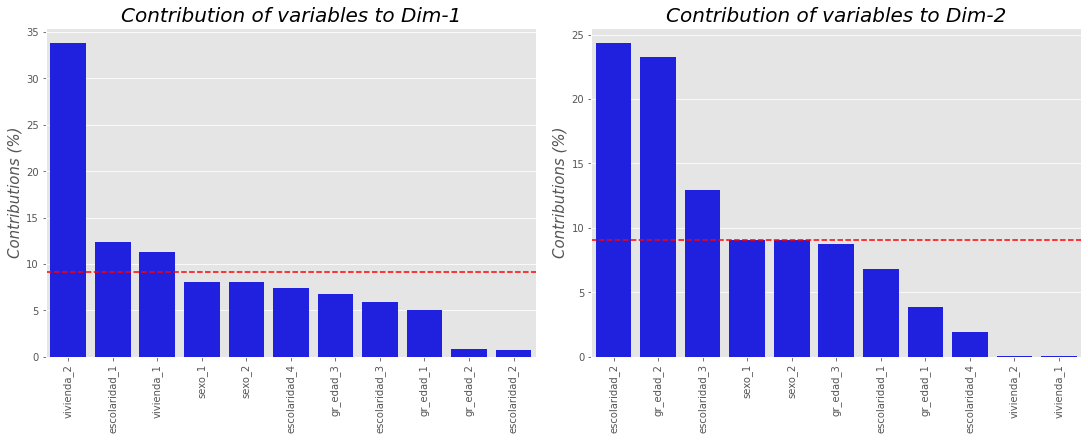

In [24]:
plot_contrib_mca(ca,X1,choice = "columns", axes1 = 1, axes2 = 2,top = 11,)

***Comentarios:***

1. Se observa que el primer eje factorial (factor 1) está
altamente determinado por la variable posesión de casa propia.

2. El factor 1 determina dos tipologías de individuos, del lado izquierdo se puede afirmar que
están quienes poseen un nivel de escolaridad universitario o más, con vivienda
propia.

3. En el lado derecho se encuentran quienes tienen un nivel de escolaridad a lo más de secundaria y que no tienen vivienda propia. 

4. El segundo eje factorial (factor 2) está definido por las modalidades asociadas a la escolaridad, discriminada
ésta por la modalidad secundaria frente a la modalidad universitario u otro.

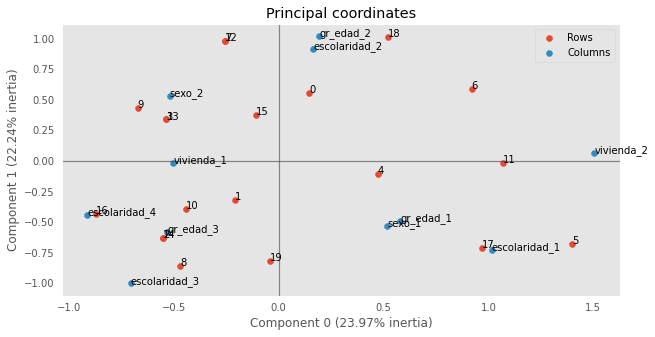

In [25]:
## Biplot librería prince. (plot_coordinates())
ax = ca.plot_coordinates(X = X1,ax = None, figsize=(10,5),x_component=0, y_component=1,
                         show_row_labels=True,show_col_labels=True,)

## ***Ejemplo 2.***

Para este ejemplo vamos a hacer uso del Dataset `poison.csv`. Estos datos son el resultado de una encuesta realizada a niños de primaria que sufrieron de malestares por presuntos alimentos en mal estado. Se les preguntó sobre sus síntomas y sobre lo que comían.

Los datos contienen 55 filas (individuos) y 15 columnas (variables).

In [26]:
poison = pd.read_csv(url_base + "poison.csv")
poison.head()

,Age,Time,Sick,Sex,Nausea,Vomiting,Abdominals,Fever,Diarrhae,Potato,Fish,Mayo,Courgette,Cheese,Icecream
0,9,22,Sick_y,F,Nausea_y,Vomit_n,Abdo_y,Fever_y,Diarrhea_y,Potato_y,Fish_y,Mayo_y,Courg_y,Cheese_y,Icecream_y
1,5,0,Sick_n,F,Nausea_n,Vomit_n,Abdo_n,Fever_n,Diarrhea_n,Potato_y,Fish_y,Mayo_y,Courg_y,Cheese_n,Icecream_y
2,6,16,Sick_y,F,Nausea_n,Vomit_y,Abdo_y,Fever_y,Diarrhea_y,Potato_y,Fish_y,Mayo_y,Courg_y,Cheese_y,Icecream_y
3,9,0,Sick_n,F,Nausea_n,Vomit_n,Abdo_n,Fever_n,Diarrhea_n,Potato_y,Fish_y,Mayo_n,Courg_y,Cheese_y,Icecream_y
4,7,14,Sick_y,M,Nausea_n,Vomit_y,Abdo_y,Fever_y,Diarrhea_y,Potato_y,Fish_y,Mayo_y,Courg_y,Cheese_y,Icecream_y


Suponga que estamos interesados en establecer las relaciones entre las siguientes variables del Dataset:

 `Nausea` `Vomiting`, `Abdominals`, `Fever`, `Diarrhae`, `Potato`, `Fish`, `Mayo`, `Courgette`, `Cheese`


In [27]:
df2 = poison.iloc[:,4:]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Nausea      55 non-null     object
 1   Vomiting    55 non-null     object
 2   Abdominals  55 non-null     object
 3   Fever       55 non-null     object
 4   Diarrhae    55 non-null     object
 5   Potato      55 non-null     object
 6   Fish        55 non-null     object
 7   Mayo        55 non-null     object
 8   Courgette   55 non-null     object
 9   Cheese      55 non-null     object
 10  Icecream    55 non-null     object
dtypes: object(11)
memory usage: 4.9+ KB


Vamos a cambiar los nombres de las modalidades por `y` y `n` en cada variable:

In [28]:
def replace_name_cate(string):
  """
      Esta función cambia los nombre de las categorías en cada una de las variables categóricas a usar.
      Example: "Sick_y", se reemplaza por "y". "Abdo_n" se reemplaza por "n". De igual forma en todos
                los casos.
  """
  string = re.findall("(?<=_)([\w]*)",string)
  return string[0]

df2 = df2.applymap(replace_name_cate)
df2 = df2.astype("category")
df2.head()

,Nausea,Vomiting,Abdominals,Fever,Diarrhae,Potato,Fish,Mayo,Courgette,Cheese,Icecream
0,y,n,y,y,y,y,y,y,y,y,y
1,n,n,n,n,n,y,y,y,y,n,y
2,n,y,y,y,y,y,y,y,y,y,y
3,n,n,n,n,n,y,y,n,y,y,y
4,n,y,y,y,y,y,y,y,y,y,y


Recordemos que la cantidad de dimensiones máximas es:

$$p-k = 22-11=11$$

Donde $p$ es el número de las distintas modalidades en las variables categóricas y $k$ es el número de variables

In [29]:
## Cantidad máxima de dimensiones.
pd.get_dummies(df2, drop_first=True).shape[1]

11

Los gráficos siguientes se pueden utilizar para identificar categorías de variables con una frecuencia muy baja. Estas tipos de variables pueden distorsionar el análisis y deben eliminarse.

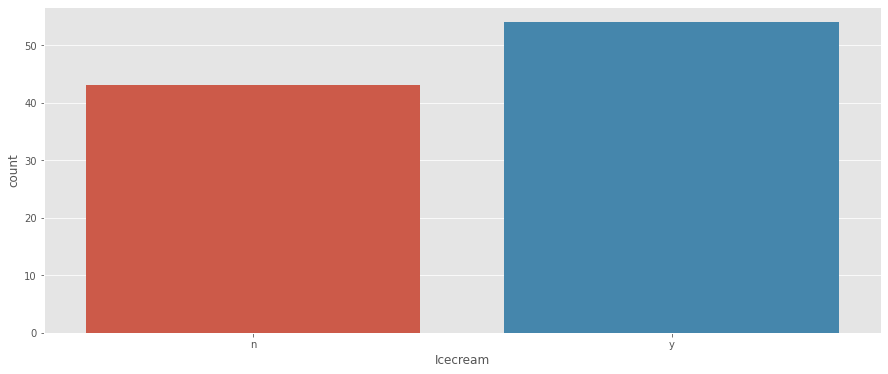

In [30]:
### Resumen de la información.
for i in df2.columns:
  #plt.figure(figsize=(6,3))
  sns.countplot(df2[i])
  #plt.show()

In [31]:
df2_mca2 = pd.get_dummies(df2)                      ## Tabla disyunta (get_dummies data original).
##
mca2 = prince.CA(n_components=11, n_iter = 10,      ## Creamos y ajustamos un objeto CA de la 
                 copy = True, check_input = True,   ## librería price sobre la tabla disyunta.
                 engine="auto", random_state=42
                 ).fit(df2_mca2)
mca2

CA(n_components=11, random_state=42)

In [32]:
## Varianzas retenidas.
get_eigenvalue(mca2)

,eigenvalue,variance_percent,cumulative_variance_percent
Dim1,0.335,33.5,33.5
Dim2,0.129,12.9,46.4
Dim3,0.107,10.7,57.1
Dim4,0.096,9.6,66.7
Dim5,0.079,7.9,74.6
Dim6,0.071,7.1,81.7
Dim7,0.060,6.0,87.7
Dim8,0.056,5.6,93.3
Dim9,0.041,4.1,97.4
Dim10,0.013,1.3,98.7


Para visualizar los porcentajes de inercia explicados por cada dimensión del ***CMA***, usamos la función `mca_screeplot()`:

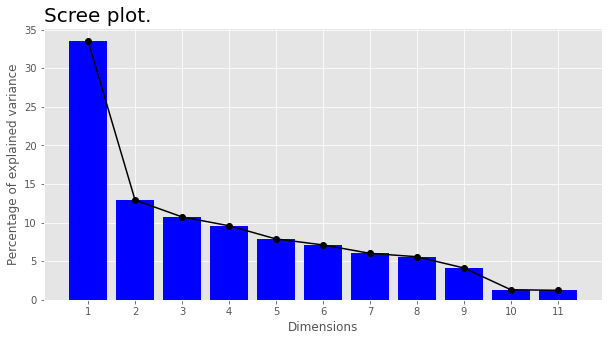

In [33]:
mca_screeplot(mca2, figsize = (10,5))

La función `mca_biplot()` (creada en el protocolo) se usa para dibujar el biplot de individuos y categorías de las variables:

In [34]:
mca_biplot(mca2,df2_mca2,1,2)

La correlación entre variables y dimensiones principales
ayuda a identificar las variables que están más correlacionadas con cada dimensión. En este caso hacemos uso del $cos2$ para graficarlas.


In [35]:
plot_var_corr(mca2,df2,df2_mca2)

***Se puede observar que, las variables: `Diarrhae`, `Abdominals` y `Fever` son las más correlacionadas
con dimensión 1. Así mismo, las variables `Courgette` y `Potato` son las más correlacionadas con la dimensión 2.***


Las dimensiones 1 y 2 son suficientes para retener el $46\%$ de la inercia total (variación) contenida en el
datos. No todos los puntos se muestran igual de bien en las dos dimensiones.


In [36]:
mca_plot_cos2(mca2,df2_mca2,choice = "columns", top = 22, size = 11)

Tenga en cuenta que las categorías variables `Fish_n`, `Fish_y`, `Icecream_n` y `Icecream_y` no están muy bien
representada por las dos primeras dimensiones. Esto implica que la posición de los puntos correspondientes
en el diagrama de dispersión debe interpretarse con cierta precaución.

La contribución de las modalidades de las variables (en %) a la definición de las dimensiones se puede plotear de la siguiente manera.

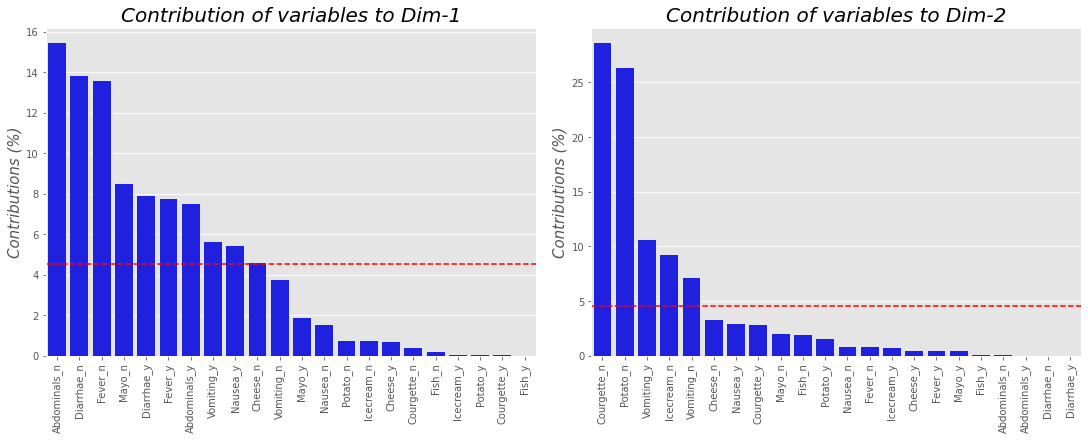

In [37]:
plot_contrib_mca(mca2,df2_mca2, choice = "columns", top = 22)

***Del plot anterior se puede ver que:***



- Las categorías `Abdominals_n`, `Diarrhea_n`, `Fever_n` y `Mayo_n` son las más importantes en la definición
de la primera dimensión.

- Las categorías `Courgette_n`, `Potato_n`, `Vomiting_y` y `Icecream_n` son las que más aportan a la dimensión
2

### ***Plots de los individuos.***



In [38]:
mca_plot_cos2(mca2,df2_mca2, choice = "index", top = 60)

In [39]:
mca_biplot(mca2,df2_mca2,)

A apesar que no se tiene una alta inercia retenida por los 2 primeros ejes, se puede observar como se forman dos grupos de individuos que se relacionan via las modalidades de las diferentes variables categóricas. ***No olvide*** que los comentarios al respecto depende tanto de la contribución al eje y de los valores en $cos2$.

## ***Referencias:***

1. _Análisis estadístico de datos multivariados. Díaz L & Morales M. Editorial: Publicaciones Facultad de ciencias. UNAL._

2. _Multivariate Analysis II. Kassambara A. Disponible en: http://www.sthda.com/english/_

##Tarea-- Revisar el ejemplo 2, tarea grupo


## ***Tarea 2.***

Realizar en grupos de hasta 3 integrantes. Entregar en formato pdf la solución junto con el archivo .ipynb

+ La tabla de informacion `Clientes.xlsx` (en el repositorio del curso) información sobre hábitos de compra de clientes en un establecimiento comercial. Determine mediante un análisis de correspondencias múltiple si existe relación entre el sexo del
cliente, la clase de cliente y forma pago de los mismos.